GCN [SEMI-SUPERVISED CLASSIFICATION WITH
GRAPH CONVOLUTIONAL NETWORKS](https://arxiv.org/pdf/1609.02907)

In [1]:
from load import Load_Data_Construct_A_For_GNN
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data = Load_Data_Construct_A_For_GNN(dir1='/content/drive/MyDrive/cora.content.txt', dir2='/content/drive/MyDrive/cora.cites', device=device)

In [4]:
fts, lbls, A, idx_train, idx_val, idx_test = data.load_data()

In [5]:
fts.shape, lbls, A.shape

(torch.Size([2708, 1433]),
 tensor([0, 5, 6,  ..., 1, 2, 0], device='cuda:0'),
 torch.Size([2708, 2708]))

In [6]:
class GCN_layer(nn.Module):
  def __init__(self, nfeat, nhid, bias=True):
    super().__init__()
    self.W = nn.Parameter(torch.randn(nfeat, nhid))
    if bias:
      self.bias = nn.Parameter(torch.randn(nhid))
    else:
      self.register_parameter('bias', None)
    self.reset_params()

  def reset_params(self):
    stdv = 1. / math.sqrt(self.W.data.size(1))
    self.W.data.uniform_(-stdv, stdv)
    if self.bias is not None:
      self.bias.data.uniform_(-stdv, stdv)


  def forward(self, x, adj):
    x = torch.matmul(x, self.W)
    x = torch.matmul(adj, x)
    if self.bias is not None:
      return x + self.bias
    else:
      return x


In [7]:
class GCN(nn.Module):
  def __init__(self, nfeat, nhid, nclass):
    super().__init__()
    self.layer1 = GCN_layer(nfeat, nhid)
    self.layer2 = GCN_layer(nhid, nclass)

  def forward(self, x, adj):
    x = self.layer2(F.dropout(F.relu(self.layer1(x, adj)), 0.5, training=self.training), adj)
    return F.log_softmax(x, dim=1)

In [22]:
model = GCN(fts.shape[1], 128, lbls.max().item()+1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
def valid(y_hat, lbls):
  _, pred = torch.max(y_hat, 1)
  acc = (pred == lbls).sum().item() / len(lbls)
  return acc

In [24]:
best_val_loss = float('inf')

In [25]:
loss_train_lst = []
loss_val_lst = []
acc_train_lst = []
acc_val_lst = []

In [26]:
for epoch in range(200):
  model.train()
  y_hat = model(fts, A)
  loss_train = F.nll_loss(y_hat[idx_train], lbls[idx_train])
  loss_train_lst.append(loss_train.item())
  acc_train = valid(y_hat[idx_train], lbls[idx_train])
  acc_train_lst.append(acc_train)
  optimizer.zero_grad()
  loss_train.backward()
  optimizer.step()

  model.eval()
  with torch.no_grad():
    y_hat = model(fts, A)
    loss_val = F.nll_loss(y_hat[idx_val], lbls[idx_val])
    loss_val_lst.append(loss_val.item())
    acc_val = valid(y_hat[idx_val], lbls[idx_val])
    acc_val_lst.append(acc_val)

  print('epoch:{}, loss_train:{:.4f}, acc_train:{:.4f}, loss_val:{:.4f}, acc_val:{:.4f}'.format(
      epoch+1, loss_train, acc_train, loss_val, acc_val
  ))

  if loss_val < best_val_loss:
    best_val_loss = loss_val
    torch.save(model.state_dict(), 'best_model.pth')

epoch:1, loss_train:2.0997, acc_train:0.1000, loss_val:2.0838, acc_val:0.1087
epoch:2, loss_train:2.0862, acc_train:0.1000, loss_val:2.0742, acc_val:0.1087
epoch:3, loss_train:2.0807, acc_train:0.1000, loss_val:2.0648, acc_val:0.1087
epoch:4, loss_train:2.0677, acc_train:0.1000, loss_val:2.0555, acc_val:0.1087
epoch:5, loss_train:2.0478, acc_train:0.1000, loss_val:2.0463, acc_val:0.1087
epoch:6, loss_train:2.0407, acc_train:0.1000, loss_val:2.0373, acc_val:0.1087
epoch:7, loss_train:2.0279, acc_train:0.1000, loss_val:2.0284, acc_val:0.1087
epoch:8, loss_train:2.0146, acc_train:0.1000, loss_val:2.0197, acc_val:0.1087
epoch:9, loss_train:2.0194, acc_train:0.1000, loss_val:2.0112, acc_val:0.1087
epoch:10, loss_train:1.9914, acc_train:0.1000, loss_val:2.0029, acc_val:0.1087
epoch:11, loss_train:1.9970, acc_train:0.1071, loss_val:1.9947, acc_val:0.1087
epoch:12, loss_train:1.9824, acc_train:0.1000, loss_val:1.9866, acc_val:0.1087
epoch:13, loss_train:1.9763, acc_train:0.1000, loss_val:1.978

In [27]:
epochs = list(np.arange(1, 201))

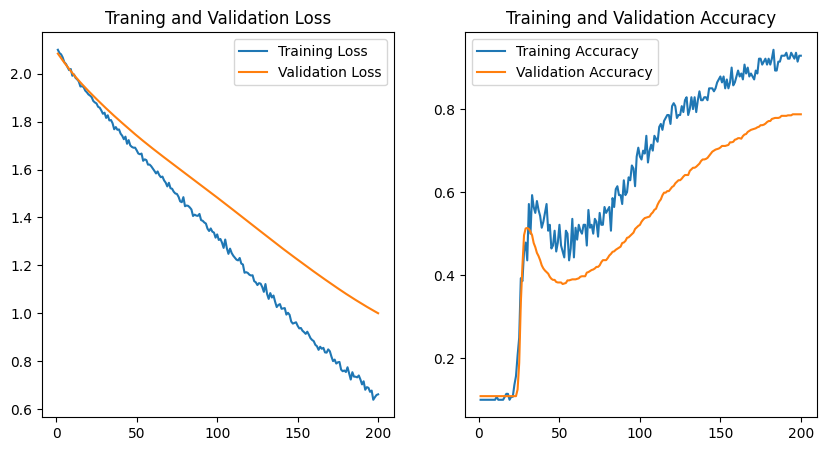

In [28]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_train_lst, label='Training Loss')
plt.plot(epochs, loss_val_lst, label='Validation Loss')
plt.title('Traning and Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_train_lst, label='Training Accuracy')
plt.plot(epochs, acc_val_lst, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [29]:
!pip install scikit-learn

In [30]:
from sklearn.metrics import f1_score

In [31]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [34]:
model.eval()
y_hat = model(fts, A)
f1_score(lbls[idx_test].cpu().detach().numpy(), y_hat[idx_test].cpu().detach().numpy().argmax(axis=1), average='micro')

0.734